# NeuralEE on PBMC Dataset

`PBMC` Dataset consists of 12,039 human peripheral blood mononu-clear cells profiled with 10x, and biologically meaningful clusters are obtained by the software Seurat.

In [1]:
import random
import numpy as np
import torch

from neuralee.embedding import NeuralEE
from neuralee.dataset import PbmcDataset 
from neuralee._aux import scatter

%matplotlib inline

Choose a GPU if a GPU available. It could be defined as follow:
```
device = torch.device('cuda:0')
device = torch.device('cuda:1')
device = torch.device('cpu')
```

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

To reproduce the following results, fix the random seed.

In [3]:
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

First, we apply log(1 + x) transformation to each element of the cell-gene expression matrix. 
Then, We retain top 500 genes ordered by variance. 
Finally, we normalize the expression of each gene by subtracting its mean and dividing its standard deviation.

In [4]:
pbmc_dataset = PbmcDataset(save_path='../')
pbmc_dataset.log_shift()
pbmc_dataset.subsample_genes(500)  
pbmc_dataset.standardscale()

File ../gene_info_pbmc.csv already downloaded
File ../pbmc_metadata.pickle already downloaded
File ../10X/pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
File ../10X/pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Keeping 33694 genes
Downsampling from 12721 to 11990 cells
Downsampling from 33694 to 3346 genes
Downsampling from 3346 to 500 genes


We apply NeuralEE with different hyper-paramters.
`N_small` takes from {1.0, 0.5, 0.25}, while `N_smalls`= 1.0 means not applied with stochastic optimization.
`lam` takes from {1, 10}.
`perplexity` fixs as 30.

Compute affinity, perplexity=30.0, on entire dataset
Compute affinity, perplexity=30.0, N_small=11990, on each batch
Neural Elastic Embedding, lambda=1, completed in 25.92s.
Neural Elastic Embedding, lambda=10, completed in 23.92s.
Compute affinity, perplexity=30.0, N_small=5995, on each batch
Neural Elastic Embedding, lambda=1, completed in 13.72s.
Neural Elastic Embedding, lambda=10, completed in 13.96s.
Compute affinity, perplexity=30.0, N_small=2997, on each batch
Neural Elastic Embedding, lambda=1, completed in 9.24s.
Neural Elastic Embedding, lambda=10, completed in 9.23s.


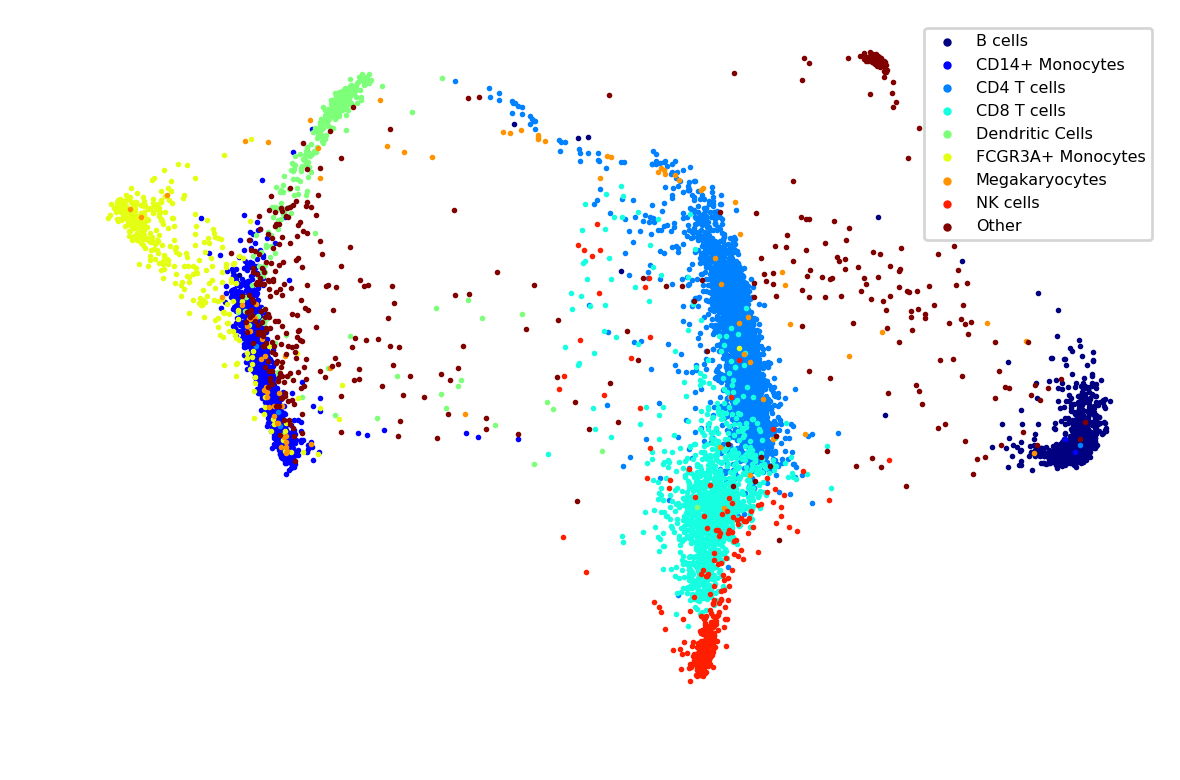

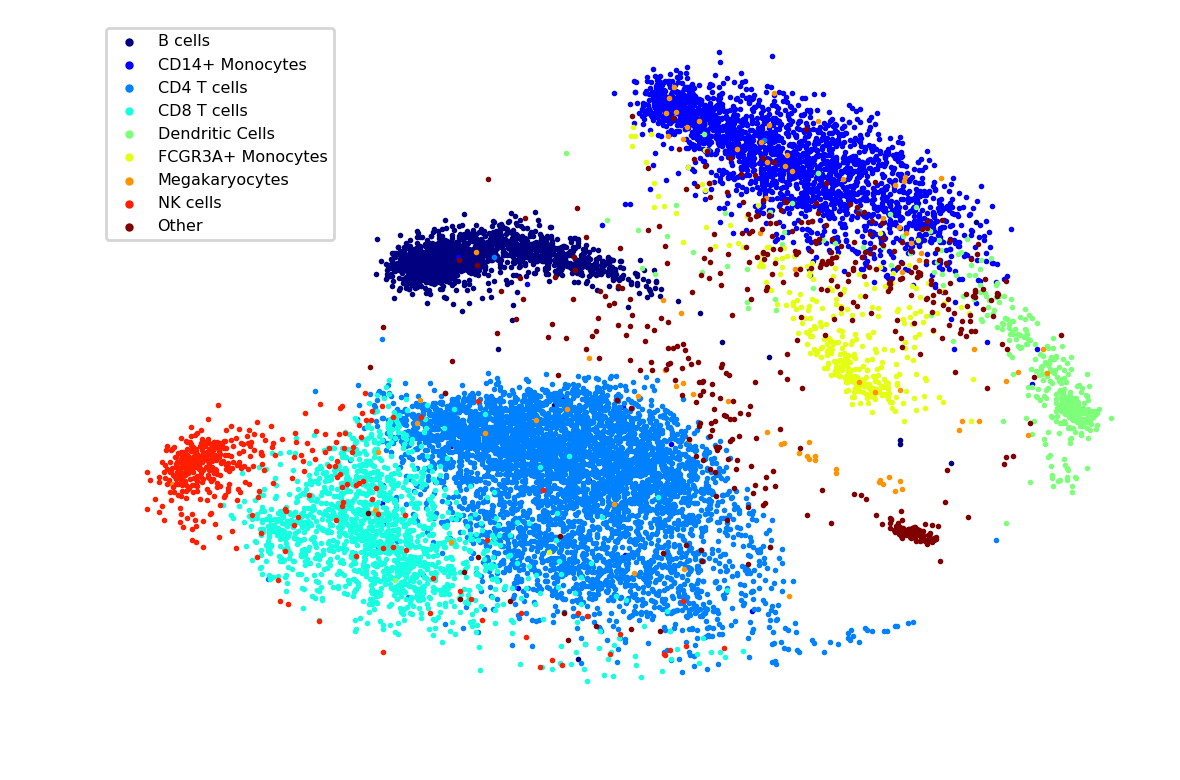

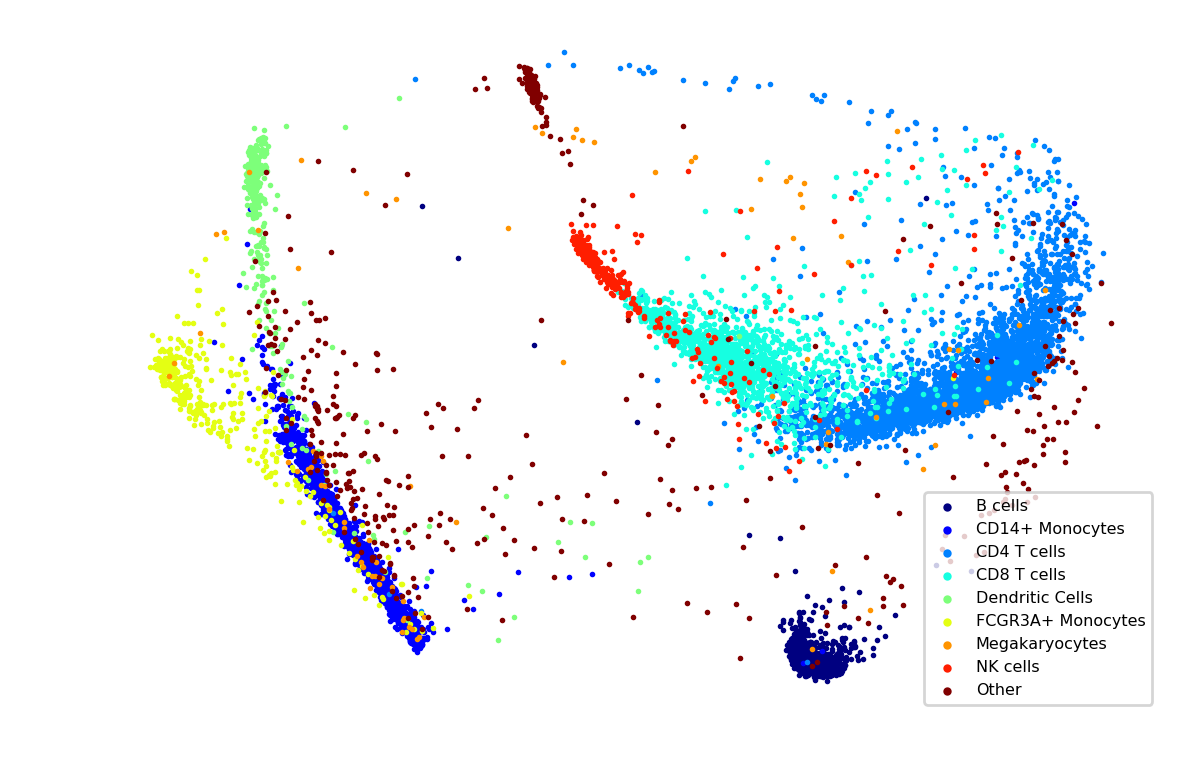

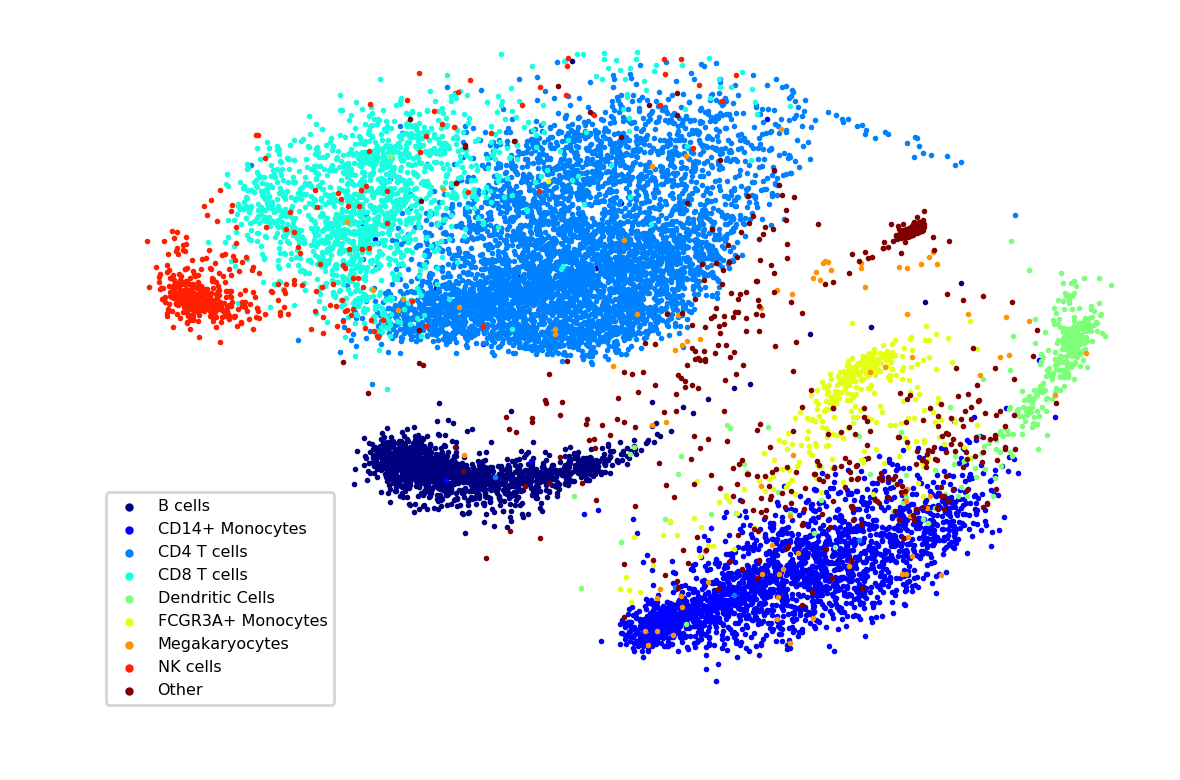

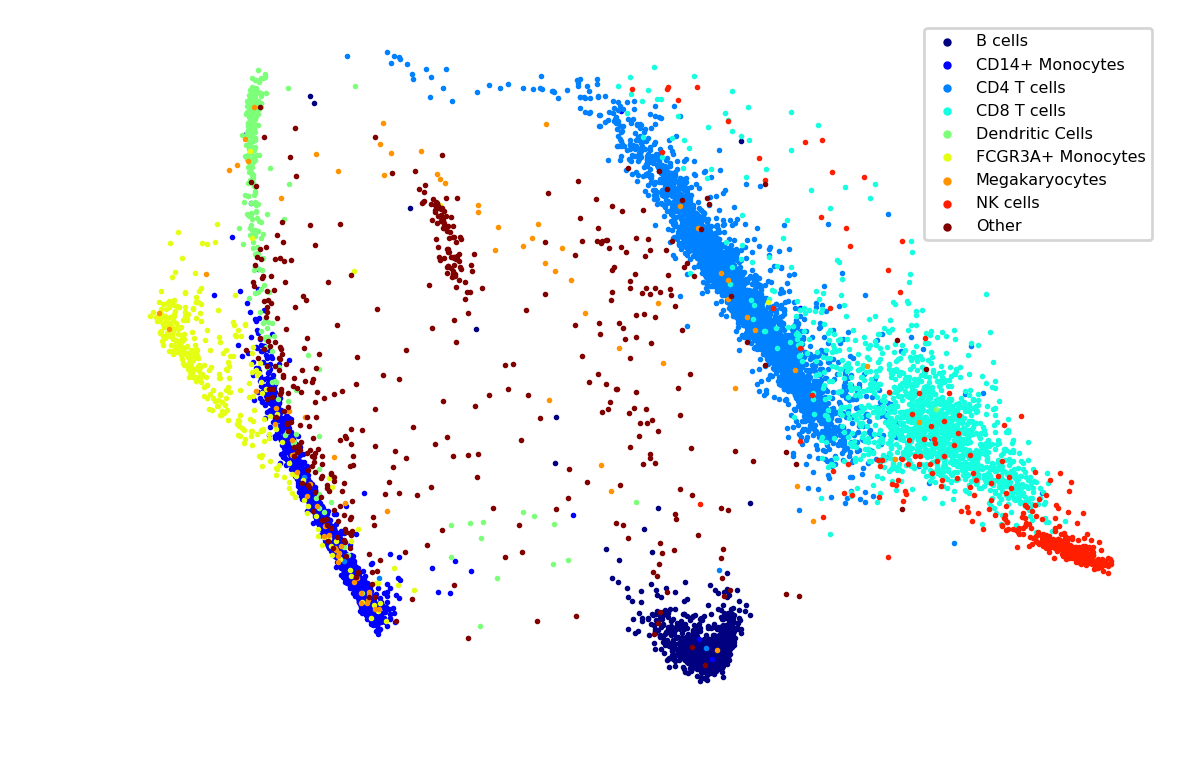

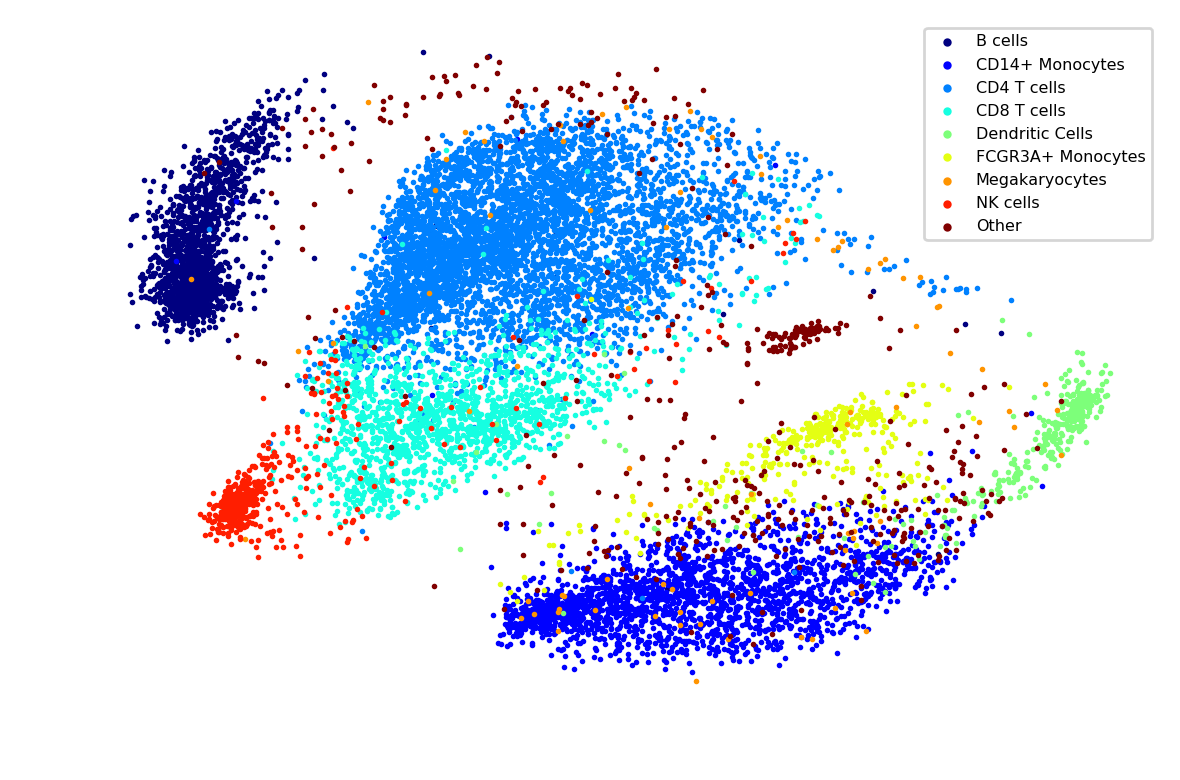

In [5]:
N_smalls = [1.0, 0.5, 0.25]
N_str = ["nobatch", "2batches", "4batches"]
lams = [1, 10]

pbmc_dataset.affinity(perplexity=30.0)
for i in range(len(N_smalls)):
    pbmc_dataset.affinity_split(N_small=N_smalls[i], perplexity=30.0)
    for lam in lams:
        NEE = NeuralEE(pbmc_dataset, lam=lam, device=device)
        results_Neural = NEE.fine_tune()
        np.save('embedding/PBMC_' + 'lam' + str(lam) + '_' + N_str[i], results_Neural['X'].numpy())
        scatter(results_Neural['X'].numpy(), NEE.labels, 
                pbmc_dataset.cell_types)